# Glider Accident Data Analysis

## Introduction

This report presents an analysis of glider accident reports available from the National Transportation Safety Board (NTSB). The purpose of the report is to identify the leading causes of accidents and provide recommendations to the glider pilot community on how to improve safety. The analysis is based on data available from 1983 up to June 2023.

## Methods

The data used in this analysis includes glider accident reports available from the NTSB's CAROL Query tool, and information on the number of gliders built for each make and mode, collected independently. The accident reports were analyzed using various data analysis and Natural Language Processing (NLP) techniques. The analysis involved the following steps:

1. **Data Loading and Preprocessing**: The data was loaded from JSON and CSV files and preprocessed to clean and format it for analysis.
2. **Exploratory Data Analysis**: The preprocessed data was explored to understand the distribution of accidents by injury severity, make and model of gliders, and accident rates.
3. **Time Series Analysis**: The data was analyzed to understand the trend of accidents over time.
4. **Text Preprocessing**: The narrative text in the accident reports was preprocessed by removing punctuation and special characters, converting all text to lower case, tokenizing the text into individual words, removing stop words, and lemmatizing the words to their root form.
5. **Topic Modeling**: The preprocessed text was used to perform Topic Modeling using [Non-negative Matrix Factorization (NMF)](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) and [Latent Dirichlet Allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to identify the common themes or issues in the accident narratives.

# Data Import and Preprocessing

The data is imported from a JSON file and preprocessed using a function to flatten nested dictionaries. The 'cm_probableCause' column, which contains the probable causes of the accidents, is preprocessed using Natural Language Processing (NLP) techniques.

## All libraries

In [1]:
import pandas as pd
import numpy as np
import json
import re
import textwrap
from textwrap import wrap
import string
from fuzzywuzzy import fuzz, process
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.preprocessing import normalize
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

/Users/alejandroleda/Documents/Py/gliderAviationSafety/.venv/lib/python3.12/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alejandroleda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alejandroleda/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alejandroleda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Function definitions

In [2]:
def flatten_json(nested_json, exclude=['']):
    """Flatten json object with nested keys into a single level.
        Args:
            nested_json: A nested json object.
            exclude: Keys to exclude from output.
        Returns:
            The flattened json object if successful, None otherwise.
    """
    out = {}

    def flatten(x, name='', exclude=exclude):
        if type(x) is dict:
            for a in x:
                if a not in exclude: flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(nested_json)
    return out

# Define function for text preprocessing
def preprocess_text(text):
    # Check if input is a string
    if not isinstance(text, str):
        return ''
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    words = word_tokenize(text)
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    return ' '.join(words)

# Define function for text preprocessing that outputs lists of words
def preprocess_text_list(text):
    # Check if input is a string
    if not isinstance(text, str):
        return []
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    words = word_tokenize(text)
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    return words

# Define a function to match the make and model names using fuzzy matching
def fuzzy_join(df1, df2, key1, key2, threshold=90, limit=1):
    s = df2[key2].tolist()

    m = df1[key1].apply(lambda x: process.extract(x, s, limit=limit))
    df1['matches'] = m

    m2 = df1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df1['matches'] = m2

    return df1

In [3]:
# Load the JSON file
with open('data/cases2023-06-03_22-15.json', 'r') as f:
    data = json.load(f)

# Flatten the JSON data
flattened_data = [flatten_json(d) for d in data]

# Convert to a pandas DataFrame
df = pd.DataFrame(flattened_data)
df

,cm_mkey,airportId,airportName,cm_closed,cm_completionStatus,cm_hasSafetyRec,cm_highestInjury,cm_isStudy,cm_mode,cm_ntsbNum,...,cm_vehicles_2_revenueSightseeing,cm_vehicles_2_secondPilotPresent,cm_vehicles_1_cm_events_2_cm_eventNum,cm_vehicles_1_cm_events_2_cicttEventSOEGroup,cm_vehicles_1_cm_events_2_cicttPhaseSOEGroup,cm_vehicles_1_cm_events_2_cm_eventCode,cm_vehicles_1_cm_events_2_cm_isDefiningEvent,cm_vehicles_1_cm_events_2_cm_sequenceNum,cm_vehicles_1_cm_events_2_cm_tier1Num,cm_vehicles_1_cm_events_2_cm_tier2Num
0,107132,7NC5,None,False,In work,False,Minor,False,Aviation,ERA23LA207,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,122570,AZ67,EL TIRO,False,In work,False,None,False,Aviation,WPR23LA182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,106616,N/A,None,False,In work,False,Serious,False,Aviation,ERA23LA115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,106089,VG55,Burner Airport,False,In work,False,None,False,Aviation,ERA23LA013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,106045,4S2,KEN JERNSTEDT AIRFIELD,True,Completed,False,None,False,Aviation,WPR22LA364,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,20806,Q00,LITTLEFIELD,True,Completed,False,None,False,Aviation,FTW83LA112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1354,20700,35R,HEMPSTEAD,True,Completed,False,Fatal,False,Aviation,FTW83FA102,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1355,23543,,DESERT AIR SKY RANCH,True,Completed,False,Serious,False,Aviation,LAX83FUG14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1356,16009,,,True,Completed,False,None,False,Aviation,DEN83FTE05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Geographic distribution of accidents

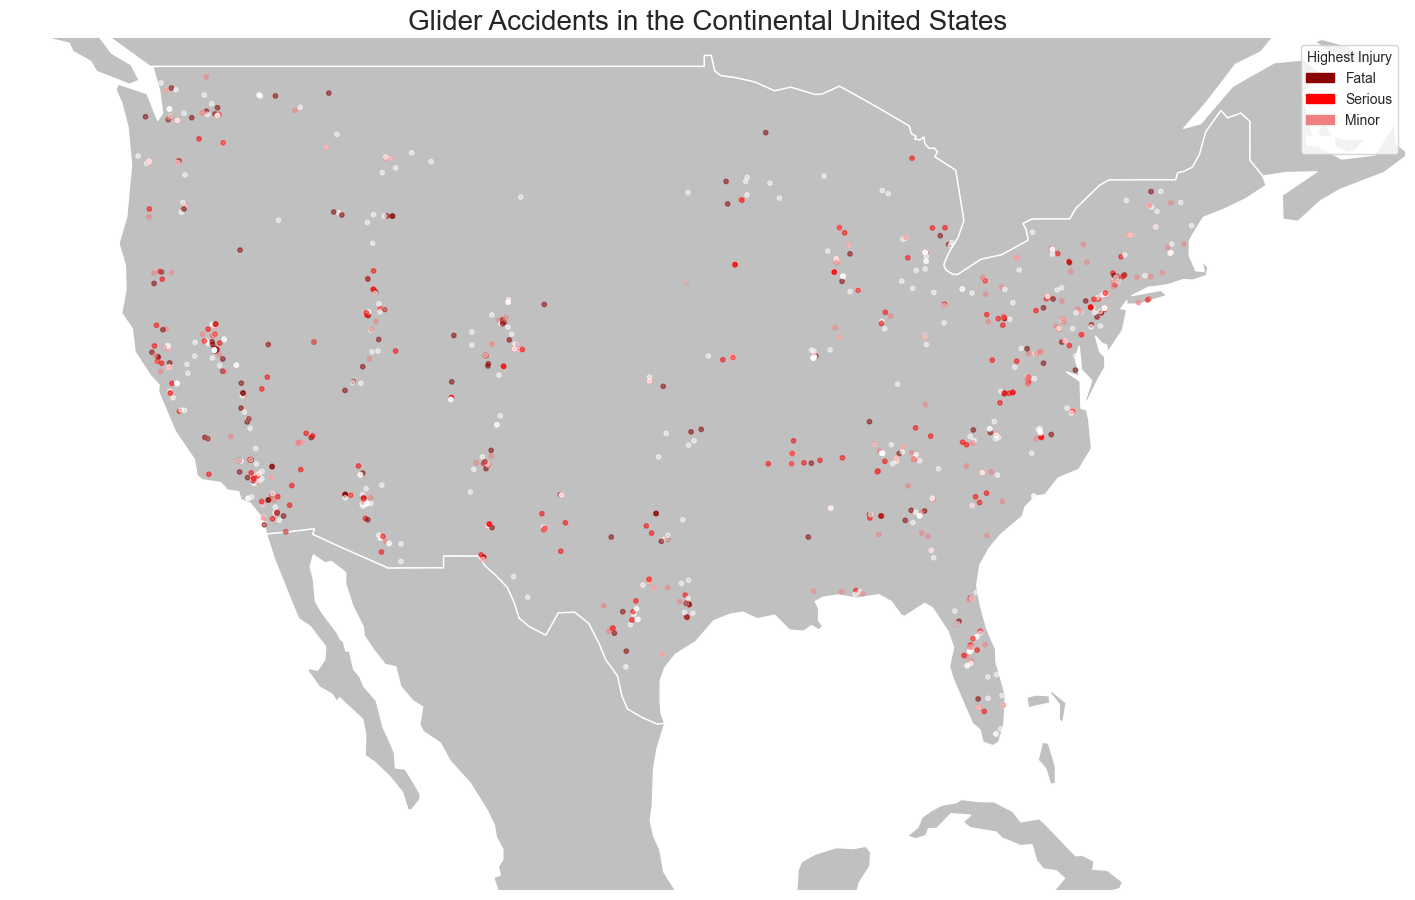

In [4]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df['geometry'] = gpd.points_from_xy(df.cm_Longitude, df.cm_Latitude)
geo_df = gpd.GeoDataFrame(df, geometry='geometry')

# Restrict the map to the 48 states of the continental United States
ax = world[world.continent == 'North America'].plot(color='silver', edgecolor='white')
ax.set_xlim(-130, -60)
ax.set_ylim(20, 50)

# Make the map larger
fig = plt.gcf()
fig.set_size_inches(18, 18)

# Filter out the points that are not in the continental United States
geo_df = geo_df[geo_df.cm_Latitude < 50]
geo_df = geo_df[geo_df.cm_Latitude > 20]
geo_df = geo_df[geo_df.cm_Longitude < -60]
geo_df = geo_df[geo_df.cm_Longitude > -130]

# Define color mapping
color_mapping = {'Fatal': 'darkred', 'Serious': 'red', 'Minor': 'lightcoral', 'None': 'white', None: 'white'}
colors = geo_df.cm_highestInjury.map(color_mapping)

# Add the points to the map using scatter plot for better legend handling
scatter = ax.scatter(geo_df.geometry.x, geo_df.geometry.y, c=colors, s=10, alpha=0.5)

# Create a legend
legend_labels = {v: mpatches.Patch(color=v, label=k) for k, v in color_mapping.items()}
plt.legend(handles=legend_labels.values(), title='Highest Injury')

# Add a title
plt.title('Glider Accidents in the Continental United States', fontsize=20)

# Remove the axis
plt.axis('off')

# Show the map
plt.show()


# NTSB's findings
Findings cited in the Report Text

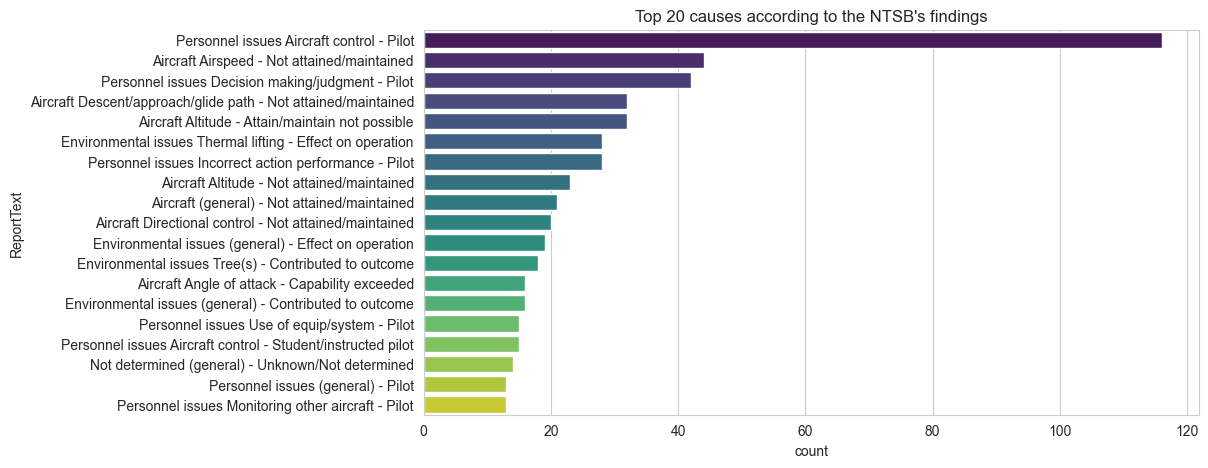

In [5]:
# Provide the value counts for each value in columns with 30 or less unique values
value_counts = {}

for column in df.columns:
  if 'ReportText' in column:
      value_counts[column] = df[column].value_counts().to_dict()

# Concatenate the first level of the value_counts nested dictionary and sum the values for each distinct key on the second level
summed_values = {}

for column, counts in value_counts.items():
    for key, value in counts.items():
        if key in summed_values:
            summed_values[key] += value
        else:
            summed_values[key] = value

summed_values = pd.DataFrame.from_dict(summed_values,  orient="index", columns=['count'])
summed_values.index.name = "ReportText"
summed_values = summed_values.sort_values(by='count', ascending=False)

# Display the top 20 causes cited by the NTSB's findings
plt.figure(figsize=(10, 5))
sns.barplot(x='count', y='ReportText', data=summed_values.reset_index().iloc[0:19], palette='viridis')
plt.title("Top 20 causes according to the NTSB's findings")
plt.show()

## Phases of flight

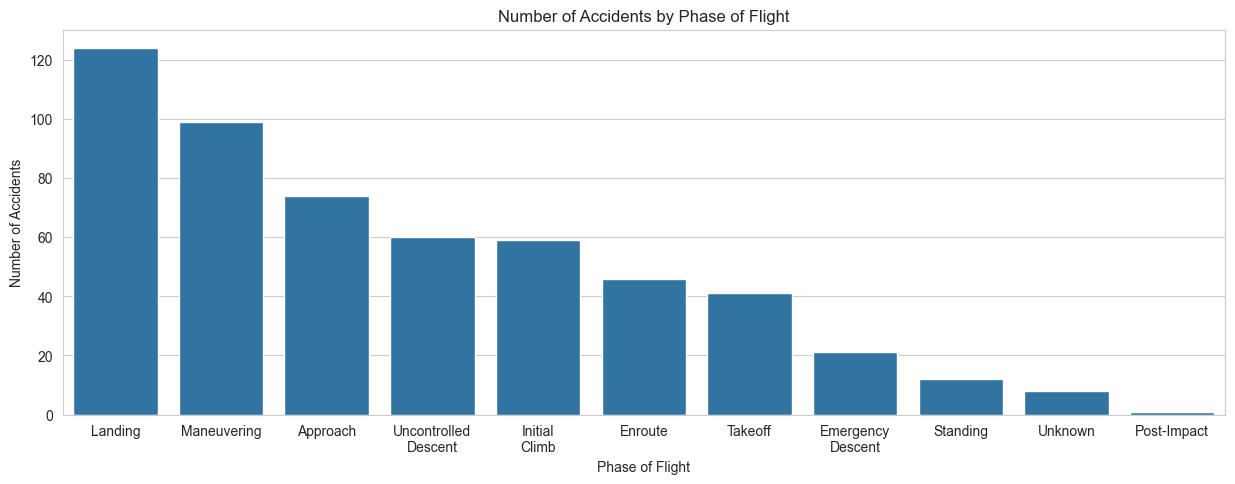

In [6]:
# List to store the extracted vehicles and events
extracted_data = []

# Iterate through the data
for entry in data:
  if (entry['cm_highestInjury'] == 'None'):
    continue
  for key in entry.keys():
    # Check if 'vehicles' key exists
    if 'vehicles' in key:
        # Iterate through the vehicles
        for vehicle in entry[key]:
            # Check if 'events' key exists in vehicle
            for vehicle_key in vehicle.keys():
              if 'events' in vehicle_key:
                  # Iterate through the events
                  for event in vehicle[vehicle_key]:
                    extracted_data.append({
                        'vehicle': vehicle,
                        'event': event
                    })

# Flatten the JSON data
flattened_data = [flatten_json(d) for d in extracted_data]

# Convert to a pandas DataFrame
df_events = pd.DataFrame(flattened_data)
phases = pd.DataFrame(df_events['event_cicttPhaseSOEGroup'].value_counts())
phases.index.name = 'phases'

# Create a bar plot of the phases
plt.figure(figsize=(15, 5))
barplot = sns.barplot(x=phases.index, y=phases['count'])

# Wrap the x-axis labels
barplot.set_xticklabels([textwrap.fill(label.get_text(), 12) for label in barplot.get_xticklabels()], rotation=0)

# Add title and labels to the plot
plt.title('Number of Accidents by Phase of Flight')
plt.xlabel('Phase of Flight')
plt.ylabel('Number of Accidents')

# Show the plot
plt.show()

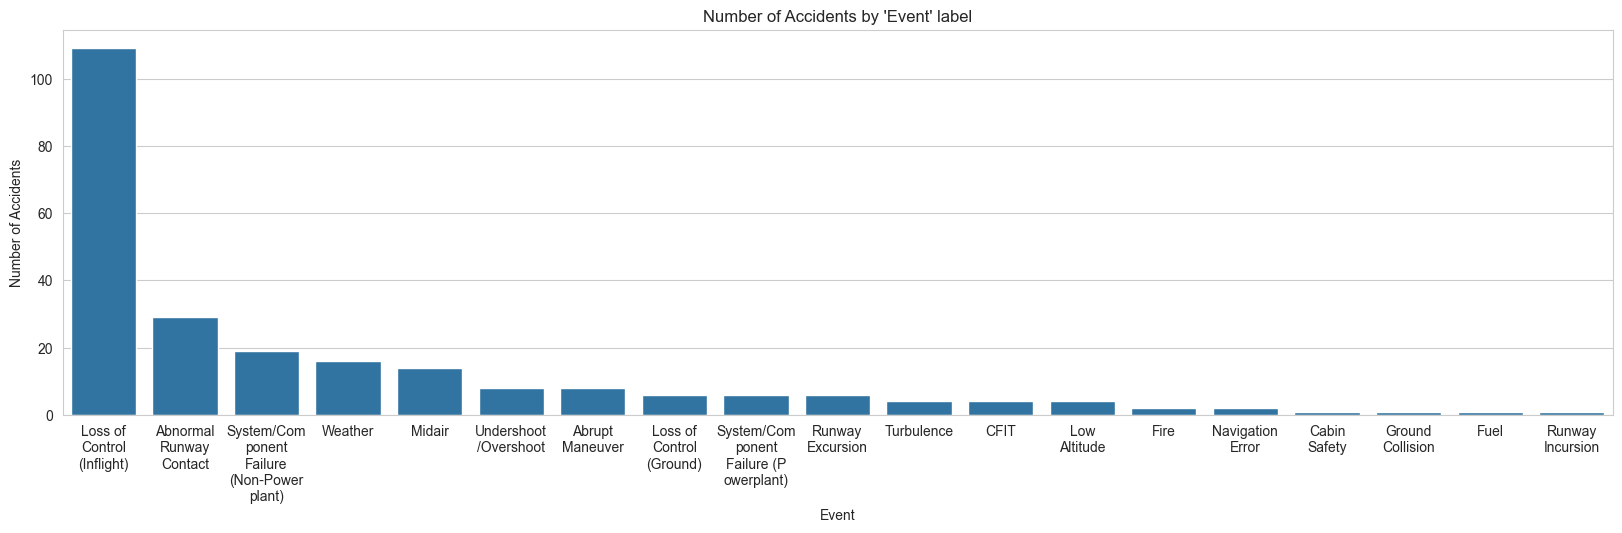

In [7]:
# Event labels
# List to store the extracted vehicles and events
extracted_data = []

# Iterate through the data
for entry in data:
  if (entry['cm_highestInjury'] == 'None'):
    continue
  for key in entry.keys():
    # Check if 'vehicles' key exists
    if 'vehicles' in key:
        # Iterate through the vehicles
        for vehicle in entry[key]:
            # Check if 'events' key exists in vehicle
            for vehicle_key in vehicle.keys():
              if 'events' in vehicle_key:
                  # Iterate through the events
                  for event in vehicle[vehicle_key]:
                    extracted_data.append({
                        'vehicle': vehicle,
                        'event': event
                    })

# Flatten the JSON data
flattened_data = [flatten_json(d) for d in extracted_data]

# Convert to a pandas DataFrame
df_events = pd.DataFrame(flattened_data)
events = pd.DataFrame(df_events['event_cicttEventSOEGroup'].value_counts())
events.drop('Other', inplace=True) # Drop 'Other' as it's non-informative

# Create a bar plot of the phases
plt.figure(figsize=(20, 5))
barplot = sns.barplot(x=events.index, y=events['count'])

# Wrap the x-axis labels
barplot.set_xticklabels([textwrap.fill(label.get_text(), 10) for label in barplot.get_xticklabels()], rotation=0)

# Add title and labels to the plot
plt.title("Number of Accidents by 'Event' label")
plt.xlabel('Event')
plt.ylabel('Number of Accidents')

# Show the plot
plt.show()

# Text Analysis of Probable Causes

The 'cm_probableCause' column is analyzed using advanced NLP techniques to identify common themes or keywords. This involves tokenizing the text, removing stop words, and lemmatizing the words.

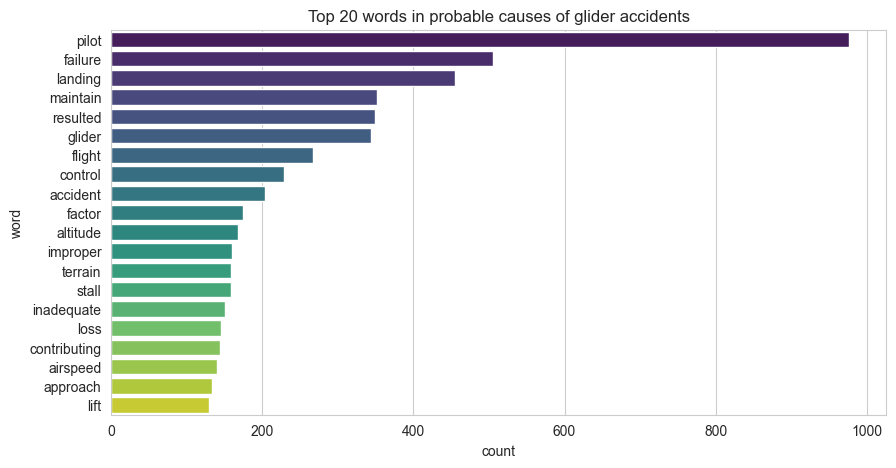

In [8]:
# Simple word count removing stop words
# Drop rows where 'cm_probableCause' is NaN
df_causes = df.dropna(subset=['cm_probableCause'])

# Initialize CountVectorizer
vec = CountVectorizer(stop_words='english')

# Fit and transform the 'cm_probableCause' column
X = vec.fit_transform(df_causes['cm_probableCause'])

# Sum up the counts of each word
word_counts = np.array(np.sum(X, axis=0)).reshape((-1,))
words = np.array(vec.get_feature_names_out())

# Create a DataFrame with the words and their counts
word_count_df = pd.DataFrame({'word': words, 'count': word_counts})

# Sort the DataFrame by 'count' in descending order and reset the index
word_count_df = word_count_df.sort_values('count', ascending=False).reset_index(drop=True)

# Display the top 20 words
plt.figure(figsize=(10, 5))
sns.barplot(x='count', y='word', data=word_count_df.loc[0:19, :], palette='viridis')
plt.title('Top 20 words in probable causes of glider accidents')
plt.show()

## Topic Modeling

The analysis using Non-Negative Matrix Factorization (NMF) on the narrative descriptions of glider accidents has revealed five distinct topics, each characterized by a set of key words. These topics provide insights into different aspects and causes of the accidents:

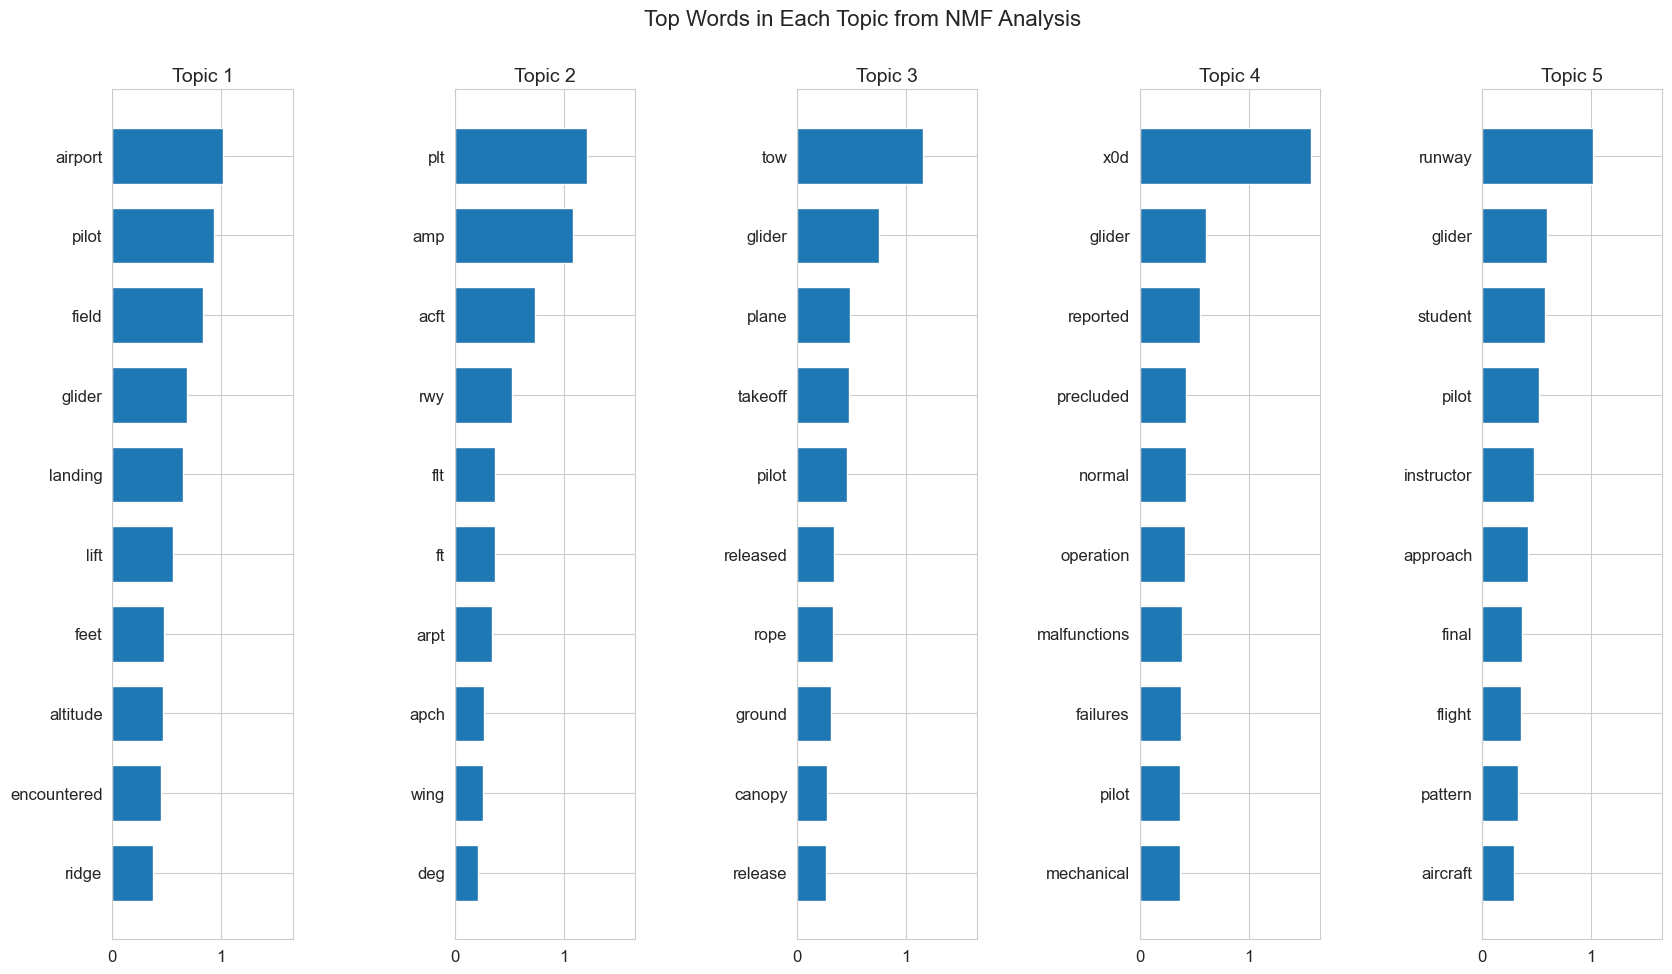

In [9]:
# Extracting the narrative descriptions
narratives = [case.get('analysisNarrative') for case in data if case.get('analysisNarrative')]

# Filtering out cases without a narrative
narratives = [narr for narr in narratives if narr]

# Vectorizing the narrative texts for NMF (Non-Negative Matrix Factorization)
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(narratives)

# Applying NMF to extract topics
nmf = NMF(n_components=5, random_state=42)
W = nmf.fit_transform(X)
H = nmf.components_

# Getting the feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Displaying the top words for each topic
num_top_words = 10
top_words = {f'Topic {i+1}': [feature_names[index] for index in H[i].argsort()[-num_top_words:][::-1]] for i in range(nmf.n_components)}

# Function to display top words for each topic in a bar plot
def display_top_words_for_topics(H, feature_names, n_top_words=10):
    fig, axes = plt.subplots(1, 5, figsize=(20, 10), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(H):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx + 1}', fontdict={'fontsize': 14})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=12)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.suptitle('Top Words in Each Topic from NMF Analysis', fontsize=16)
    plt.show()

# Displaying the top words for each topic in a bar plot
display_top_words_for_topics(H, feature_names)

1. **Topic 1 - Airport and Landing:** Key words like 'airport', 'field', 'glider', 'landing', and 'lift' suggest this topic is related to accidents occurring near or at the airport, possibly during landing phases. The mention of 'lift' and 'feet' might indicate issues with altitude or lift management during final approach.

2. **Topic 2 - Pilot Actions and Aircraft Conditions:** Words like 'plt' (pilot), 'amp', 'acft' (aircraft), 'rwy' (runway), and 'flt' (flight) indicate a focus on the pilot's actions and the condition of the aircraft. This could include pilot decision-making, handling of the aircraft, and runway operations.

3. **Topic 3 - Tow Plane and Takeoff Operations:** This topic, with words such as 'tow', 'glider', 'plane', 'takeoff', and 'pilot', is likely related to the initial phase of glider flights where the glider is towed by another plane. Incidents during takeoff or involving the tow rope are suggested by 'released', 'rope', and 'ground'.

4. **Topic 4 - Mechanical and Operational Failures:** The presence of words like 'x0d', 'reported', 'precluded', 'normal operation', 'malfunctions', and 'failures' indicates discussions about mechanical issues or operational failures in gliders. This topic might capture accidents where a mechanical fault or operational issue was a contributing factor.

5. **Topic 5 - Training and Flight Patterns:** This topic includes words like 'runway', 'glider', 'student', 'pilot', 'instructor', 'approach', 'final', 'flight', 'pattern', and 'aircraft'. It seems to be related to training flights or learning scenarios, including approach patterns and instruction.

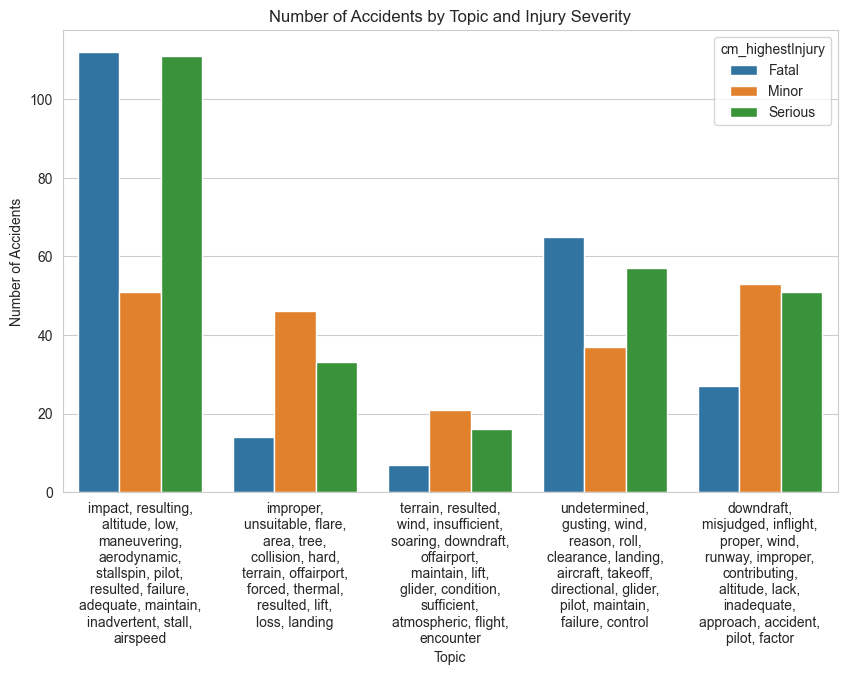

In [10]:
# Define function for text preprocessing
def preprocess_text(text):
    # Check if input is a string
    if not isinstance(text, str):
        return []
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    words = word_tokenize(text)
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    return words

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Preprocess the 'cm_probableCause' text
df['cm_probableCause_preprocessed'] = df['cm_probableCause'].apply(preprocess_text)

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Join the words into a single string
df['cm_probableCause_preprocessed'] = df['cm_probableCause_preprocessed'].apply(' '.join)

# Now apply the vectorizer
tfidf_matrix = vectorizer.fit_transform(df['cm_probableCause_preprocessed'])

# Convert the matrix to a DataFrame for easier viewing
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Initialize NMF model with 5 components (topics)
nmf = NMF(n_components=5, random_state=42)

# Fit the model to the TF-IDF matrix
nmf.fit(tfidf_matrix)

# Add the topic assignments to the original DataFrame
df['topic'] = nmf.transform(tfidf_matrix).argmax(axis=1)

# Group data by topic and cm_highestInjury, and count the number of accidents in each group
topic_injury_counts = df.groupby(['topic', 'cm_highestInjury']).size().reset_index(name='counts')

# Filter accidents with no injuries
topic_injury_counts = topic_injury_counts[topic_injury_counts['cm_highestInjury'] != 'None']

# Create a bar plot of the accident counts with wrapped topic labels
plt.figure(figsize=(10, 6))
sns.barplot(x='topic', y='counts', hue='cm_highestInjury', data=topic_injury_counts)
plt.title('Number of Accidents by Topic and Injury Severity')
plt.xlabel('Topic')
plt.ylabel('Number of Accidents')

# Get the top 15 words for each topic
topic_words = []
for i, topic in enumerate(nmf.components_):
    top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-15:]]
    topic_words.append(', '.join(top_words))

# Wrap the topic labels and rotate them 90 degrees
plt.xticks(range(5), ['\n'.join(wrap(label, 20)) for label in topic_words], rotation=0)
plt.show()

The visualization presents the top words in each of the five topics identified from the NMF analysis of the narrative descriptions of glider accidents. Each bar represents the weight or prominence of a word within its respective topic:

- **Topic 1:** Focuses on airport and landing-related aspects.
- **Topic 2:** Highlights pilot actions and aircraft conditions.
- **Topic 3:** Emphasizes tow plane operations and takeoff.
- **Topic 4:** Relates to mechanical and operational failures.
- **Topic 5:** Pertains to training, flight patterns, and approaches.

# Accidents Over Time

The number of accidents is plotted over time, broken down by injury severity. This shows the evolution of accidents and injury severity over time.

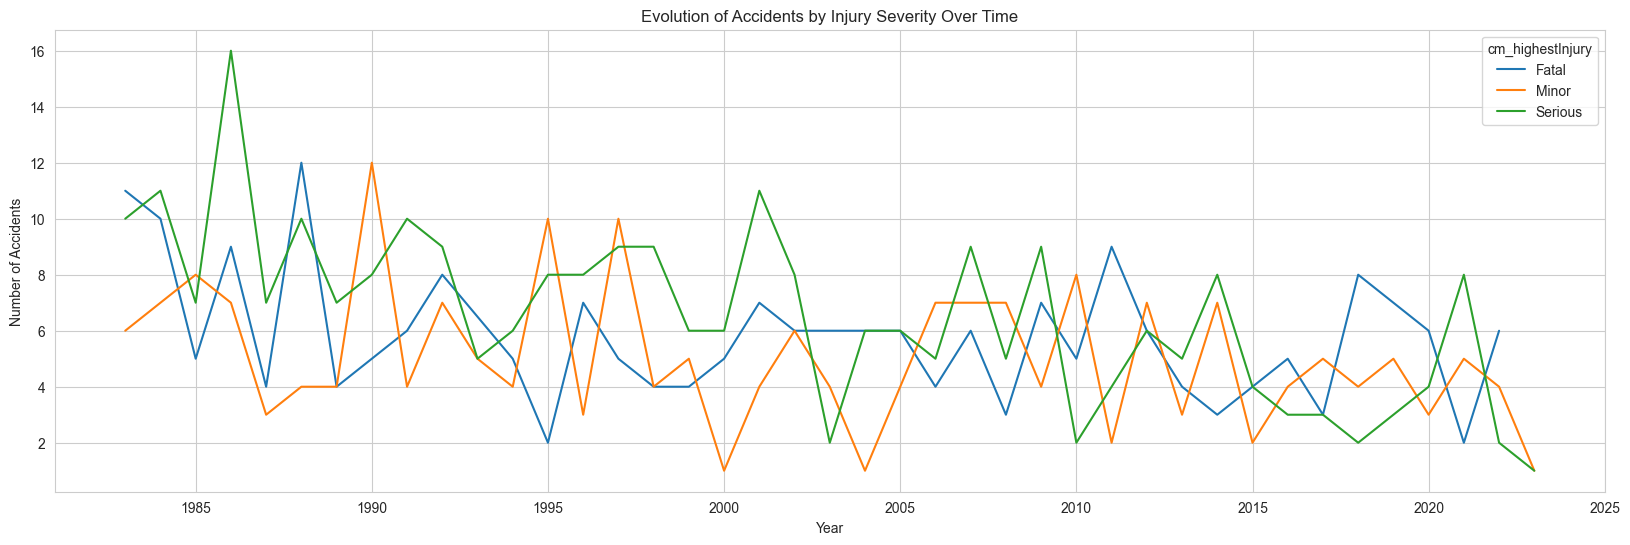

In [11]:
# Plot
# Convert 'cm_eventDate' to datetime format
df['cm_eventDate'] = pd.to_datetime(df['cm_eventDate'])

# Extract year from 'cm_eventDate'
df['year'] = df['cm_eventDate'].dt.year

# Count the number of accidents for each year and injury severity
year_injury_counts = df.groupby(['year', 'cm_highestInjury']).size().reset_index(name='counts')

# Filter accidents with no injuries
year_injury_counts = year_injury_counts[year_injury_counts['cm_highestInjury'] != 'None']

# Create a line plot of the accident counts over time
plt.figure(figsize=(20, 6))
sns.lineplot(x='year', y='counts', hue='cm_highestInjury', data=year_injury_counts)
plt.title('Evolution of Accidents by Injury Severity Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.show()

## Accidents by Make and Model

The make and model of gliders most commonly involved in accidents are identified, and the number of accidents for each make and model is broken down by injury severity. This information is compared with the number of gliders built for each make and model to calculate the accident rate per glider built.

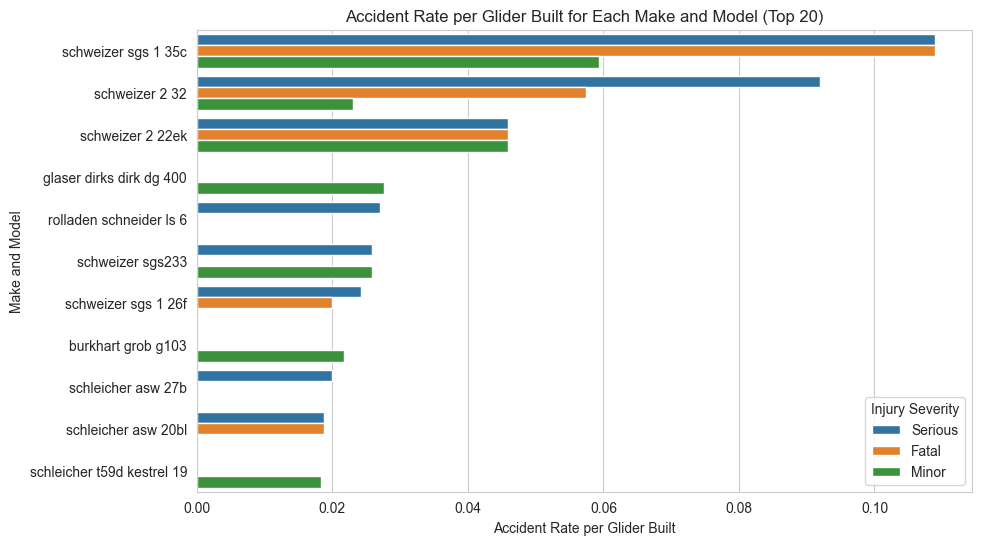

In [12]:
# Plot
# Import the num_gliders_built.csv file
df_gliders_built = pd.read_csv('data/num_gliders_built.csv')

# Concatenate the 'cm_vehicles_0_make' and 'cm_vehicles_0_model' columns in the original DataFrame
df['make_model'] = df['cm_vehicles_0_make'] + ' ' + df['cm_vehicles_0_model']

# Concatenate the 'cm_vehicles_0_make' and 'cm_vehicles_0_model' columns in the num_gliders_built DataFrame
df_gliders_built['make_model'] = df_gliders_built['cm_vehicles_0_make'] + ' ' + df_gliders_built['cm_vehicles_0_model']

# Fill missing values in the 'make_model' column in the original DataFrame with an empty string
df['make_model'] = df['make_model'].fillna('')

# Apply the fuzzy_join function to the accident and gliders_built dataframes
df = fuzzy_join(df, df_gliders_built, 'make_model', 'make_model', threshold=80)

# Count the number of accidents for each make and model and injury severity
make_model_injury_counts = df.groupby(['matches', 'cm_highestInjury']).size().reset_index(name='counts')

# Merge the accident counts with the gliders_built dataframe
df_merged = pd.merge(make_model_injury_counts, df_gliders_built.drop('counts', axis=1), left_on='matches', right_on='make_model', how='left')

# Convert the 'number built' column to numeric values
df_merged['number built'] = pd.to_numeric(df_merged['number built'], errors='coerce')

# Calculate the accident rate per glider built
df_merged['accident_rate'] = df_merged['counts'] / df_merged['number built']

# Remove the entry for 'Schweizer PRG 1' from the DataFrame. States 1 glider built and 5 accidents indicating inconsistent data
df_merged = df_merged[df_merged['matches'] != 'Schweizer PRG 1'.lower()]

# Sort the DataFrame by the accident rate
df_merged = df_merged.sort_values('accident_rate', ascending=False)

# Remove the entries where 'Injury Severity' is 'None' from the DataFrame
df_merged = df_merged[df_merged['cm_highestInjury'] != 'None']

# Select the top 20 results
df_top20 = df_merged.head(20)

# Create a bar plot of the accident rate per glider built for each make and model
plt.figure(figsize=(10, 6))
sns.barplot(x='accident_rate', y='matches', hue='cm_highestInjury', data=df_top20, ci=None)
plt.xlabel('Accident Rate per Glider Built')
plt.ylabel('Make and Model')
plt.title('Accident Rate per Glider Built for Each Make and Model (Top 20)')
plt.legend(title='Injury Severity')
plt.show()

# Conclusion

The analysis revealed several key findings:

- Serious and fatal accident rates remain very high. The number of accidents with 'Fatal' injuries shows some fluctuations but doesn't show a clear increasing or decreasing trend since mid-2010s.
- Most accidents are caused by pilot errors related to control of the glider, particularly during landings. In addition, stalls and inadequate airspeed, control issues during takeoff, and improper planning and decision-making were often cited as factors.
- To improve safety, the glider pilot community needs to focus on training and awareness in these areas. Continued training on landing techniques, managing atmospheric conditions, stall prevention, control during takeoff and landing, and decision-making and planning skills remains a priority.
- Additionally, more training and guidelines on the tow process, ground impact avoidance, and runway operations are needed.
- Lastly, only experienced pilots are recommended to act as PICs for the following models:
    - Schweizer 2 32: This model has the highest accident rate. There were 23 accidents with no injuries and 8 accidents with serious injuries. 87 gliders of this model were built.
    - Schweizer SGS 1 35C: This model has the second highest accident rate. There were 21 accidents with no injuries, 11 accidents with serious injuries, and 11 fatal accidents. 101 gliders of this model were built.
    - Let L Spatz 55: This model has the third highest accident rate. There were 62 accidents with no injuries. 600 gliders of this model were built.
    - Schweizer SGS233: This model has the fourth highest accident rate. There were 86 accidents with no injuries. 930 gliders of this model were built.

# Recommendations for Improving Glider Pilot Community Safety

1. **Enhanced Training on Atmospheric Conditions:** Pilots should receive more rigorous training in understanding and reacting to various atmospheric conditions, especially those affecting lift.

2. **Decision-Making and Emergency Procedures:** Emphasize training on timely decision-making, especially regarding landing decisions when conditions change unexpectedly.

3. **Focus on Landing Safety:** Given the high number of incidents during landing, special focus should be given to training for safe landing techniques under various conditions.

4. **Regular Safety Briefings and Workshops:** Organize frequent safety briefings and workshops focusing on the common causes of accidents and their prevention.

5. **Incident Analysis and Learning:** Encourage a culture of learning from past incidents, where pilots can share experiences and lessons learned.

6. **Use of Technology and Weather Forecasting Tools:** Encourage the use of advanced weather forecasting tools and technology to better prepare for and respond to atmospheric changes during flight.

7. **Mentorship and Peer Review:** Encourage experienced pilots to mentor less experienced ones, and promote peer review and discussions about flight plans and decisions.